In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from patsy import dmatrix
from sklearn import linear_model 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [2]:
df = pd.read_csv('data/ipo_stock_2010_2018_v2.csv', parse_dates=['Date Priced', 'year'])

In [3]:
print(df.shape)
df.head()

(834, 26)


,Company Name,Symbol,Market,Price,Shares,Offer Amount,Date Priced,employees,address,US_state,...,inmonth_open,inweek_adjclose,inweek_open,inyear_adjclose,inyear_open,sector,industry,employees2019,CEO_pay,CEO_born
0,ANDATEE CHINA MARINE FUEL SERVICES CORP,AMCF,NASDAQ,6.3,3134921.0,19750002.0,2010-01-26,128.0,NO. 68 BINHAI RD DALIAN XIGANG DISTRICTDALIAN ...,NaN,...,8.000000,5.830000,6.030000,2.720000,2.58,Energy,Oil & Gas Equipment & Services,189.0,NaN,NaN
1,GENERAC HOLDINGS INC.,GNRC,New York Stock Exchange,13.0,18750000.0,243750000.0,2010-02-11,1486.0,"S45 W29290 HIGHWAY 59WAUKESHA, WI 53187",WI,...,14.910000,8.612183,13.050000,13.415763,20.24,Industrials,Diversified Industrials,5046.0,2520000.0,1972.0
2,"QUINSTREET, INC",QNST,NASDAQ,15.0,10000000.0,150000000.0,2010-02-11,568.0,"950 TOWER LANE, 6TH FLOORFOSTER CITY, CA 94404",CA,...,16.010000,12.980000,13.500000,12.740000,12.52,Technology,Internet Content & Information,506.0,816150.0,1960.0
3,TERRENO REALTY CORP,TRNO,New York Stock Exchange,20.0,8750000.0,175000000.0,2010-02-10,6.0,"16 MAIDEN LANEFIFTH FLOORSAN FRANCISCO, CA 94108",CA,...,19.530001,14.770803,18.809999,13.518149,17.02,Real Estate,REIT - Industrial,23.0,799500.0,1961.0
4,"PIEDMONT OFFICE REALTY TRUST, INC.",PDM,New York Stock Exchange,14.5,12000000.0,174000000.0,2010-02-10,109.0,"5565 GLENRIDGE CONNECTORSTE 450ATLANTA, GA 30342",GA,...,19.299999,10.400203,17.830000,14.289856,21.02,Real Estate,REIT - Office,134.0,NaN,NaN


In [4]:
df.columns

Index(['Company Name', 'Symbol', 'Market', 'Price', 'Shares', 'Offer Amount',
       'Date Priced', 'employees', 'address', 'US_state', 'descriptions',
       'link_nasdaq', 'year', 'firstday_adjclose', 'firstday_open',
       'inmonth_adjclose', 'inmonth_open', 'inweek_adjclose', 'inweek_open',
       'inyear_adjclose', 'inyear_open', 'sector', 'industry', 'employees2019',
       'CEO_pay', 'CEO_born'],
      dtype='object')

In [5]:
keep_cols = ['Company Name', 'Price', 'Shares', 'Offer Amount',
       'Date Priced', 'employees', 'US_state', 'firstday_adjclose', 'firstday_open',
       'inmonth_adjclose', 'inweek_adjclose', 'sector', 'CEO_pay', 'CEO_born']

In [6]:
df = df[keep_cols]

In [7]:
#assigning to all companies that don't have US_state - foreign status
df['US_state'] = df['US_state'].apply(lambda x: 'foreign' if str(x) == 'nan' else x)

In [8]:
df['diff_close_inday_2_open_firstday'] = df['firstday_adjclose'] - df['firstday_open']

# Check for Typos in Prices

It turned out that Yahoo Finance has mistakes in historical data. I came to acknowledge this after comparing IPO offer price and scraped opening price on Yahoo Finance. The following code does just that - shows the companies where the discrepancies are higher than 2 times. I have checked few companies manually - the scraper scraped the correct data for correct company and date. However, when checked against news this Yahoo Finance data is indeed unreliable.So I decided to exclude these from the dataset.<br>

For instance, Blue Apron Inc went to IPO on 6/29/2017 with the offer price of \\$10. Yahoo Finance reports its price on 6/29/2017 as \\$150 (see also the pic below). In reality, however, it's opening and closing price was \\$10 (https://www.cnbc.com/2017/06/29/blue-apron-ipo-opening-trade.html)

<img src="assets/BlueApron_example.png" alt="drawing" height="1500" width="800"/>



In [9]:
df['check_prices'] = df['firstday_open']/df['Price']

In [10]:
typo_prices = df[(df['check_prices'] > 2) | (df['check_prices'] < -2)][['Company Name', 'Price', 'firstday_open','firstday_adjclose', 'inweek_adjclose']]

In [11]:
print(typo_prices.shape[0])
typo_prices.head()

47


,Company Name,Price,firstday_open,firstday_adjclose,inweek_adjclose
7,SCORPIO TANKERS INC.,13.0,127.500000,121.557602,120.686592
23,"ROADRUNNER TRANSPORTATION SYSTEMS, INC.",14.0,343.750000,343.750000,348.750000
36,"AMYRIS, INC.",16.0,247.500000,247.500000,256.049988
43,DAQO NEW ENERGY CORP.,9.5,49.900002,51.250000,67.000000
47,GLOBUS MARITIME LTD,11.6,476.000000,488.170715,497.734833


In [12]:
df = df.drop(typo_prices.index, axis=0)

In [13]:
df.reset_index(drop=True, inplace=True)

In [14]:
df.isna().sum()

Company Name                          0
Price                                 1
Shares                                1
Offer Amount                          0
Date Priced                           0
employees                            14
US_state                              0
firstday_adjclose                     0
firstday_open                         0
inmonth_adjclose                      0
inweek_adjclose                       0
sector                               10
CEO_pay                             214
CEO_born                             70
diff_close_inday_2_open_firstday      0
check_prices                          1
dtype: int64

In [15]:
#drop 1 row where there is no Offer Price
df.drop(df[df.Price.isna()].index, axis=0, inplace=True)

In [16]:
#drop 14 rows where there are no employees
df.drop(df[df.employees.isna()].index, axis=0, inplace=True)

In [17]:
#drop 10 rows where there is no sector
df.drop(df[df.sector.isna()].index, axis=0, inplace=True)

In [18]:
df.isna().sum()

Company Name                          0
Price                                 0
Shares                                0
Offer Amount                          0
Date Priced                           0
employees                             0
US_state                              0
firstday_adjclose                     0
firstday_open                         0
inmonth_adjclose                      0
inweek_adjclose                       0
sector                                0
CEO_pay                             198
CEO_born                             58
diff_close_inday_2_open_firstday      0
check_prices                          0
dtype: int64

In [19]:
#drop rows where there is no CEO_born
df.drop(df[df.CEO_born.isna()].index, axis=0, inplace=True)

In [20]:
#drop rows where there is no CEO_pay
df.drop(df[df.CEO_pay.isna()].index, axis=0, inplace=True)

# Feature Engineering

### Weekday of the IPO day 

In [21]:
df['month'] = df['Date Priced'].map(lambda x: x.year)

In [22]:
df['month'] = df['month'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug',\
                                  9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})

In [23]:
df['weekday'] = df['Date Priced'].dt.dayofweek.map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})

In [24]:
df.shape

(565, 18)

### Market Conditions

It makes sense to add broad market conditions approximized here by S&P500. If the general stock market was down, probably this will affect the IPO prices on the first day. So I take a market change a week before IPO date and construct a new feature SP_Week_Chg. 

In [25]:
sp = pd.read_csv('data/spy.csv')

In [26]:
# we need to have our Date values ordered 
#even if it is oredered already, let's do it anyway as a good practice working with dates
sp.sort_values('Date', inplace=True)
sp.reset_index(drop=True, inplace=True)
sp.Date = pd.to_datetime(sp.Date)
sp.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [27]:
def get_week_chg(ipo_dt):
    try: 
        day_ago_idx = sp[sp['Date'] == str(ipo_dt.date())].index[0] - 1
        week_ago_idx = sp[sp['Date'] == str(ipo_dt.date())].index[0] - 8
        chg = (sp.iloc[day_ago_idx]['Close'] - sp.iloc[week_ago_idx]['Close'])/(sp.iloc[week_ago_idx]['Close'])
        return chg * 100
    except:
        print('error', ipo_dt.date())      

In [28]:
df['SP_Week_Chg'] = df['Date Priced'].map(get_week_chg)

# Outliers

In [29]:
# df.diff_close_inweek_2_open_firstday.describe()

In [30]:
# def tukey_rule(data_frame, column_name):
#     '''Implement tukey rule to remove outliers from the data_frame column-wise
    
#     Args:
#         data_frame
#         column_name (str): the column to look for outliers
    
#     Output:
#         data_frame: df without outliers
    
#     '''
#     Q1 = data_frame[column_name].quantile(0.25)
#     Q3 = data_frame[column_name].quantile(0.75)
    
#     IQR = Q3 - Q1
    
#     max_value = Q3 + 2 * IQR
#     min_value = Q3 - 2 * IQR
    
#     return data_frame[(data_frame[column_name] < max_value) & (data_frame[column_name] > min_value)]

In [31]:
# df_nooutliers = tukey_rule(df, 'diff_close_inweek_2_open_firstday')

In [32]:
# df_nooutliers.shape

# Normalizing numerical features

In [33]:
# Initialize a scaler, then apply it to the features
scaler = StandardScaler() # default=(0, 1)
numerical = ['Price', 'Shares', 'Offer Amount', 'employees', 'CEO_pay', 'CEO_born', 'SP_Week_Chg']

df[numerical] = scaler.fit_transform(df[numerical])

# Show an example of a record with scaling applied
df.head()

,Company Name,Price,Shares,Offer Amount,Date Priced,employees,US_state,firstday_adjclose,firstday_open,inmonth_adjclose,inweek_adjclose,sector,CEO_pay,CEO_born,diff_close_inday_2_open_firstday,check_prices,month,weekday,SP_Week_Chg
1,GENERAC HOLDINGS INC.,-0.304272,0.153041,-0.024445,2010-02-11,-0.079475,WI,8.460629,13.00,9.719180,8.612183,Industrials,0.833935,1.121447,-4.539371,1.000000,NaN,Thu,-1.248841
2,"QUINSTREET, INC",-0.016606,-0.126505,-0.118015,2010-02-11,-0.132927,CA,15.000000,15.00,16.410000,12.980000,Technology,-0.326281,-0.416149,0.000000,1.000000,NaN,Thu,-1.248841
3,TERRENO REALTY CORP,0.702559,-0.166440,-0.093063,2010-02-10,-0.165650,CA,14.692022,18.75,15.330121,14.770803,Real Estate,-0.337619,-0.288016,-4.057978,0.937500,NaN,Wed,-0.323599
6,SS&C TECHNOLOGIES HOLDINGS INC,-0.016606,-0.103342,-0.107160,2010-03-31,-0.093041,CT,7.181165,8.00,7.957377,7.862139,Technology,6.526577,-1.056814,-0.818835,0.533333,NaN,Wed,0.512090
8,FIRST INTERSTATE BANCSYSTEM INC,-0.088522,-0.126505,-0.123005,2010-03-24,-0.065267,MT,11.994637,16.00,12.239342,12.331657,Financial Services,0.282375,-0.416149,-4.005363,1.103448,NaN,Wed,1.054108


# Modelling

I will predict the IPO price change on the first day of trading. If it grew more than \\$1, then I consider it a success. I use these features in my model:
- Price, Shares, Offer Amount and Employees from Nasdaq data on IPO
- sector, CEO_pay, CEO_born and SP_Week_Chg - from Yahoo Finance

I also calculate the total **predicted return** from using the model and compare it to the **actual return** (if all IPOs which prices went higher than $1 on the first day of trading were predicted correctly - practically impossible task) and the **return using the naive approach** - i.e. when we invested in each and every IPO - buying it at opening price and selling at closing price.

## Splitting into X and Y

In [35]:
X = dmatrix("Q('Price') + Q('Shares') + Q('Offer Amount') + Q('employees') + \
            Q('sector') + Q('CEO_pay') + Q('CEO_born') + Q('SP_Week_Chg') + Q('weekday')", data=df, return_type='dataframe')

In [36]:
X.shape

(565, 22)

In [37]:
#predict success if IPO's price is $2 higher in a week than at the opening
y = df['diff_close_inday_2_open_firstday'].apply(lambda x: 1 if x >= 1 else 0)
print('number of true positives -', y.sum())

number of true positives - 101


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.05)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
#evaluate the model on hold-out data
print('accuracy score:', clf.score(X_test, y_test))

accuracy score: 0.7610619469026548


In [40]:
def create_results_df(X_train, X_test, y_pred, y_test):
    
    results = []
    for idx, chg, ypred, ytrue in zip(y_test.index, df['diff_close_inday_2_open_firstday'][y_test.index], y_pred, y_test):
        if ypred == ytrue:
            results.append([idx, chg, ypred, ytrue, 1])
        else:
            results.append([idx, chg, ypred, ytrue, 0])
    return pd.DataFrame(results, columns=['index', '$_chg', 'predicted', 'actual', 'correct'])

In [41]:
def return_model_keyresults(results_df):
    summ_pred = results_df[results_df.predicted == 1]['$_chg'].sum()
    mean_pred = results_df[results_df.predicted == 1]['$_chg'].mean()
    total_pred = results_df.predicted.sum()
    
    summ_actual = results_df[results_df.actual == 1]['$_chg'].sum()
    mean_actual = results_df[results_df.actual == 1]['$_chg'].mean()
    total_actual = results_df.actual.sum()
    
    summ_naive = results_df['$_chg'].sum()
    mean_naive = results_df['$_chg'].mean()
    total_naive = len(results_df['$_chg'])
    print('actual:' , results_df.actual.sum())
    print('predicted', results_df.predicted.sum())
    print('predicted return: ${:0.2f} for {} IPOs -- ${:0.2f} per IPO '.format(summ_pred, total_pred, mean_pred))
    print('actual return: ${:0.2f} for {} IPOs -- ${:0.2f} per IPO '.format(summ_actual, total_actual, mean_actual))
    print('naive return: ${:0.2f} for {} IPOs -- ${:0.2f} per IPO '.format(summ_naive, total_naive, mean_naive))

In [42]:
rf = create_results_df(X_train, X_test, y_pred, y_test)

In [43]:
return_model_keyresults(rf)

actual: 27
predicted 10
predicted return: $7.32 for 10 IPOs -- $0.73 per IPO 
actual return: $85.99 for 27 IPOs -- $3.18 per IPO 
naive return: $-34.09 for 113 IPOs -- $-0.30 per IPO 


Commentary: we can see that although the model doesn't predict all successful IPOs (as defined here), it still performs quite well with accuracy score of 76%. <br>
Well, you wouldn't become rich with this strategy. But by using the model, one could avoid financially detrimental choices in case of investing in each and every IPO (naive return).

In [44]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:10]]
    values = importances[indices][:10]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(10), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(10) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(10), columns, rotation=-70)
    plt.xlim((-0.5, 10))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

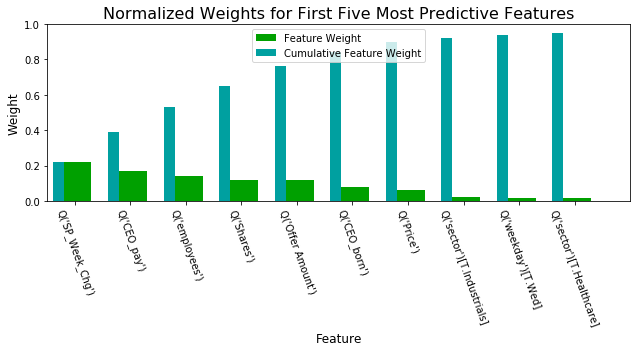

In [45]:
f_importances = clf.feature_importances_
feature_plot(f_importances, X_train, y_train);

Conclusion: from the plot above we can see that the 5 most important features are broad market conditions, offer amount, CEO_pay, number of employees and number of shares. 

# Naive Predictor

In [ ]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# TODO: Calculate accuracy, precision and recall
accuracy = np.sum(y)/y.count()
recall = 1
precision = np.sum(y)/y.count()

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + 0.5**2) * precision * recall / (0.5**2 * precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

In [ ]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score
from time import time
from sklearn.metrics import accuracy_score, fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)[:300]
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = 0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [ ]:
# TODO: Initialize the three models
clf_A = RandomForestClassifier(random_state = 432)
clf_B = AdaBoostClassifier(random_state = 432)
clf_C = GradientBoostingClassifier(random_state = 432)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int((len(y_train)*0.1))
samples_1 = int((len(y_train)*0.01))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [ ]:
results

# Grid Search

In [ ]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from  sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = GradientBoostingClassifier(random_state = 432)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {"n_estimators": [800, 1000, 1200],
             "learning_rate": [0.001, 0.01, 0.05, 0.1]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring =scorer, verbose=3)
#grid_obj = RandomizedSearchCV(clf, param_distributions = parameters, scoring = scorer) 

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and optimized model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

In [ ]:
best_clf